# Clustering : Boston Marathon Challenge #

## By Lorenz Madarang ##

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

### Initial Ingestion of the Data ###
I ingested the 2014 data from the Boston Marathon.  The goal of this notebook is to see how well clustering methods work in identifying male and female participants.

In [2]:
boston = pd.read_csv('https://raw.githubusercontent.com/llimllib/bostonmarathon/master/results/2014/results.csv')

In [3]:
boston.head()

,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,...,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,...,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,...,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,NaN,...,1,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,NaN,...,27,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,NaN,...,2,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


### Data Cleaning and Preparation ###
I divided the data into four samples, mapped the genders to boolean values 0 and 1 (Male and Female respectively).  Also, I created an independent variable dataset that consists of all the continuous variables in the dataset.  The dependent variable dataset consists of the boolean-mapped gender column.  I made sure that all the scores were converted to numeric and replace NaNs with 0.  I normalized the data and then I finally conducted a PCA to reduce the number of independent variables to 2.  

In [6]:
# Make sure the number of rows divides evenly into four samples.
rows = boston.shape[0] - boston.shape[0] % 4
boston = boston.iloc[:rows, :]

In [7]:
# Map gender to boolean values
z = {'M': 0, 'F': 1}

In [8]:
# Create independent and dependent dataframes
X = boston[['10k', '25k','age', 'official', '35k', 'overall', 'pace', '30k', '5k', 'half', '20k', '40k' ]]
Y = boston['gender'].map(z)

In [9]:
# Replace any weird characters
X = X.replace(to_replace='?', value=0)

In [10]:
# Convert dataframe to numeric
X = X.apply(pd.to_numeric, errors='coerce')
Y = Y.apply(pd.to_numeric, errors='coerce')

In [11]:
# Fill NA's to 0
X.fillna(0, inplace=True)

In [12]:
# Normalize the data
X_norm = normalize(X)

In [13]:
# Create predicted dataframe
ypred = pd.DataFrame()

In [14]:
# Conduct PCA to reduce the number of independent variables
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_norm)

### Creation of Clusters ###
I split the data into train and test and created four equal sized samples.  On each sample I ran a K-means clustering with 2, 3, and 4 clusters.  The cluster identification was consistent among the samples.  

In [28]:
# Split the data into four equally-sized samples. First we break it in half:
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X_norm,
    X_pca,
    test_size=0.5,
    random_state=42)

# Then we halve the halves.
X1, X2, X_pca1, X_pca2 = train_test_split(
    X_half1,
    X_pcahalf1,
    test_size=0.5,
    random_state=42)
X3, X4, X_pca3, X_pca4 = train_test_split(
    X_half2,
    X_pcahalf2,
    test_size=0.5,
    random_state=42)


In [29]:
for counter, data in enumerate([
    (X1, X_pca1),
    (X2, X_pca2),
    (X3, X_pca3),
    (X4, X_pca4)]):
    
    # Put the features into ypred.
    ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    # Generate cluster predictions and store them for clusters 8, 12, 16.
    for nclust in range(2,5):
        pred = KMeans(n_clusters=nclust, random_state=42).fit_predict(data[0])
        ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred

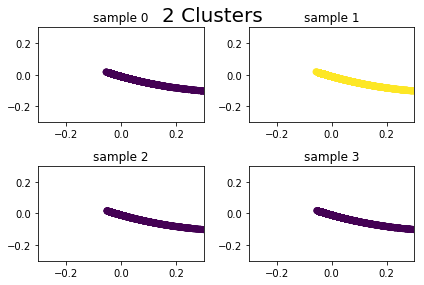

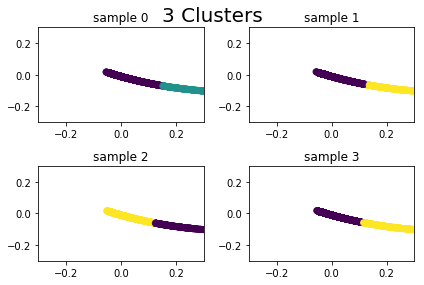

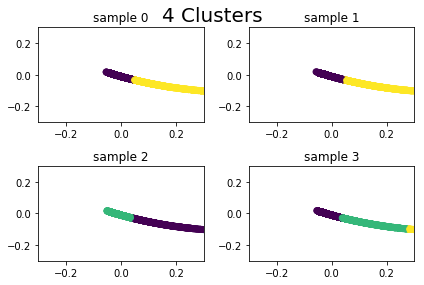

In [30]:
# For each  number of clusters, plot the clusters using the
# pca features for each sample.
for cluster in range(2,5):
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(2, 2)
    
    # Make a plot for each sample.
    for i in range(4):
        
        # PCA-created features.
        x_sub = ypred['pca_f1_sample{}'.format(i)]
        y_sub = ypred['pca_f2_sample{}'.format(i)]
        
        # Cluster assignments.
        c = ypred['clust{}_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        rows = int(np.floor(i / 2))
        cols = i % 2
        axarr[rows, cols].scatter(x_sub, y_sub, c=c)
        axarr[rows, cols].set_title('sample {}'.format(i))
        axarr[rows, cols].set_xlim([-.3, .3])
        axarr[rows, cols].set_ylim([-.3, .3])
    
    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()
    print('\n')

### Cluster Evaluation : Crosstab ###
Crosstab tables of the predicted clusters and their relation to their gender breakout.  

In [31]:
# Get predicted clusters.
full_pred = KMeans(n_clusters=2, random_state=42).fit_predict(X_norm)

pd.crosstab(Y, full_pred) 

col_0,0,1
gender,,
0,16961,656
1,14319,48


In [35]:
# Get predicted clusters.
full_pred = KMeans(n_clusters=3, random_state=42).fit_predict(X_norm)

pd.crosstab(Y, full_pred) 

col_0,0,1,2
gender,,,
0,15983,1282,352
1,14262,67,38


In [36]:
# Get predicted clusters.
full_pred = KMeans(n_clusters=4, random_state=42).fit_predict(X_norm)

pd.crosstab(Y, full_pred) 

col_0,0,1,2,3
gender,,,,
0,14761,253,538,2065
1,14170,36,18,143


### Rand Index ###
A Rand Index was conducted on the 2 k-mean cluster.  The Rand Index was about .55, this indicates the probability that the cluster assignment agrees with the ground truth of the gender category.  The Rand Index of .55 tells that there is a little bit better chance than a coin flip of agreement between cluster assignment and the actual gender category.  

In [77]:
# Note: the itertools module is tons of fun and very useful.
import itertools

# Create a list of pairs, where each pair is the ground truth group
# and the assigned cluster.
c = list(itertools.product(Y, full_pred))

# Count how often each type of pair (a, b, c, or d) appears.
RIcounts = [[x, c.count(x)] for x in set(c)]
print(RIcounts)

# Create the same counts but without the label, for easier math below.
RIcounts_nolabel = [c.count(x) for x in set(c)]

# Calculate the Rand Index.
RIscore = (RIcounts_nolabel[3] + RIcounts_nolabel[2]) / np.sum(RIcounts_nolabel)
print(RIscore)

[[(0, 1), 12402368], [(1, 0), 449399760], [(0, 0), 551059760], [(1, 1), 10114368]]
0.548570042275


### Adjusted Rand Index ###
The Adjusted Rand Index applies a correction factor based on the expected RI from randomness.  According to the ARI, this cluser assignment does slight worse than completely random.  

In [32]:
from sklearn import metrics

metrics.adjusted_rand_score(Y, full_pred)

-0.0054460301625604488

### Silhouette Coefficient ###
The Silhouette Coefficient measures how well the clusters are grouped together.  With silhouette coefficients of about .93, it looks like the clusters are grouped together pretty densely.  

In [33]:
from sklearn.metrics import pairwise_distances

for sample in [X1, X2, X3, X4]:
    model = KMeans(n_clusters=2, random_state=42).fit(sample)
    labels = model.labels_
    print(metrics.silhouette_score(sample, labels, metric='euclidean'))

0.934282765456
0.931281402532
0.929497369094
0.931154767411


### Visualization and Conclusion ###
The Cluster assignments appear to be random but the clusters are grouped together very well.  In trying to identify gender based on various run times, the differences are quite small.  As displayed by the boxplots, males have slightly faster run times.  The distributions of times are similar between the men and the women.  Because of these similarities it was difficult for the cluster algorithm to get accurate assignments that aligned with gender.  

In [21]:
boston['gender_bool'] = boston['gender'].map(z)
boston_num = boston.apply(pd.to_numeric, errors='coerce')
boston_num.fillna(0, inplace=True)

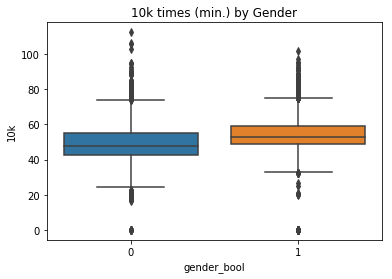

In [23]:
ax = sns.boxplot(x="gender_bool", y="10k", data=boston_num)
plt.title('10k times (min.) by Gender')

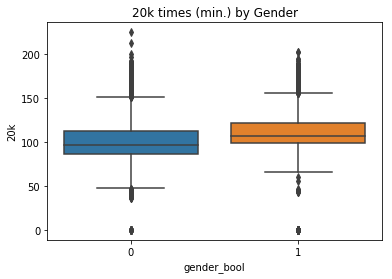

In [24]:
ax = sns.boxplot(x="gender_bool", y="20k", data=boston_num)
plt.title('20k times (min.) by Gender')

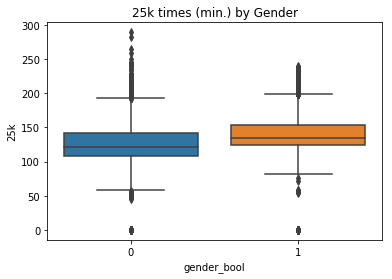

In [25]:
ax = sns.boxplot(x="gender_bool", y="25k", data=boston_num)
plt.title('25k times (min.) by Gender')

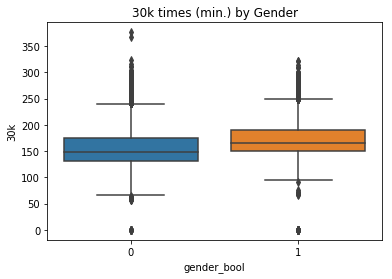

In [26]:
ax = sns.boxplot(x="gender_bool", y="30k", data=boston_num)
plt.title('30k times (min.) by Gender')